## Setup

In [1]:
import json
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define paths
result_files = {
    "Image": "../img_training/results.json",
    "Text": "../text_training/results.json",
    "Fusion (Concat, Full)": "../fusion_models/concatenation/concatenation_fusion_results.json",
    "Fusion (Concat, Half)": "../fusion_models/concatenation/smaller_concatenation_fusion_results.json",
    "Fusion (XAttn, Full)": "../fusion_models/cross_attention/cross_attn_results.json",
    "Fusion (XAttn, Half)": "../fusion_models/cross_attention/small_cross_attn_results.json",
}

def macro_avg(val):
    if isinstance(val, list):
        return sum(val) / len(val)
    return val

def load_results(model_label, path):
    with open(path, "r") as f:
        entries = json.load(f)

    rows = []
    for entry in entries:
        name = entry.get("name", "")
        combo = entry.get("combo", {})
        metrics = entry.get("metrics", {})
        for task, vals in metrics.items():
            row = {
                "Model": model_label,
                "Task": task,
                "Name": name,
                "Dropout": combo.get("dropout_rate") or combo.get("vision_drop"),
                "WeightDecay": combo.get("weight_decay"),
                "LearningRate": combo.get("learning_rate"),
                "BatchSize": combo.get("batch_size"),
                "Epochs": combo.get("num_epochs"),
                "Accuracy": vals.get("accuracy"),
                "Precision": macro_avg(vals.get("precision")),
                "Recall": macro_avg(vals.get("recall")),
                "F1": macro_avg(vals.get("f1")),
                "AUROC": vals.get("auroc"),
                "AUPRC": vals.get("auprc"),
                "Sensitivity": vals.get("sensitivity"),
                "Specificity": vals.get("specificity"),
            }
            rows.append(row)
    return rows

all_data = []
for model, path in result_files.items():
    if os.path.exists(path):
        all_data.extend(load_results(model, path))

df = pd.DataFrame(all_data)
df.to_csv("full_analysis.csv", index=False)


In [2]:
# Standardize task names to ensure consistency
df["Task"] = df["Task"].str.strip().str.title()

# Filter only Edema and Effusion
filtered_df = df[df["Task"].isin(["Edema", "Effusion"])]

# Keep only (Model, Name) pairs that have both Edema and Effusion
task_counts = filtered_df.groupby(["Model", "Name"])["Task"].nunique().reset_index()
valid_pairs = task_counts[task_counts["Task"] == 2][["Model", "Name"]]

# Merge to keep only valid pairs
valid_filtered_df = pd.merge(filtered_df, valid_pairs, on=["Model", "Name"], how="inner")

# Compute Avg F1 per (Model, Name)
avg_f1 = (
    valid_filtered_df.groupby(["Model", "Name"])["F1"]
    .mean()
    .reset_index()
    .rename(columns={"F1": "Avg_F1"})
)

# Find best Name per Model
best_names_per_model = avg_f1.loc[avg_f1.groupby("Model")["Avg_F1"].idxmax()].reset_index(drop=True)

print("Best Names per Model based on Edema & Effusion Avg F1:")
print(best_names_per_model)

# Fetch full metrics for the best configurations
best_rows = pd.merge(
    valid_filtered_df,
    best_names_per_model,
    on=["Model", "Name"],
    how="inner"
)

# Save or view
best_rows.to_csv("best_metrics_by_model.csv", index=False)


Best Names per Model based on Edema & Effusion Avg F1:
                   Model                                      Name    Avg_F1
0  Fusion (Concat, Full)      VD0.1_TD0.2_LR0.0002_WD0.1_BS16_EP20  0.954740
1  Fusion (Concat, Half)      VD0.1_TD0.1_LR0.0002_WD0.1_BS16_EP20  0.952955
2   Fusion (XAttn, Full)   CA_VD0.1_TD0.1_LR0.0002_WD0.1_BS16_EP20  0.953254
3   Fusion (XAttn, Half)  CA_VD0.1_TD0.1_LR0.0002_WD0.01_BS16_EP20  0.941565
4                  Image                 dp0.2_wd0.01_lr5e-05_bs32  0.851086
5                   Text                  dp0.1_wd0.1_lr1e-05_bs32  0.939307


## Basic Performance Comparison (Per Label)

### Recall (Sensitivity) Metric (Avg of Hyperparameters)

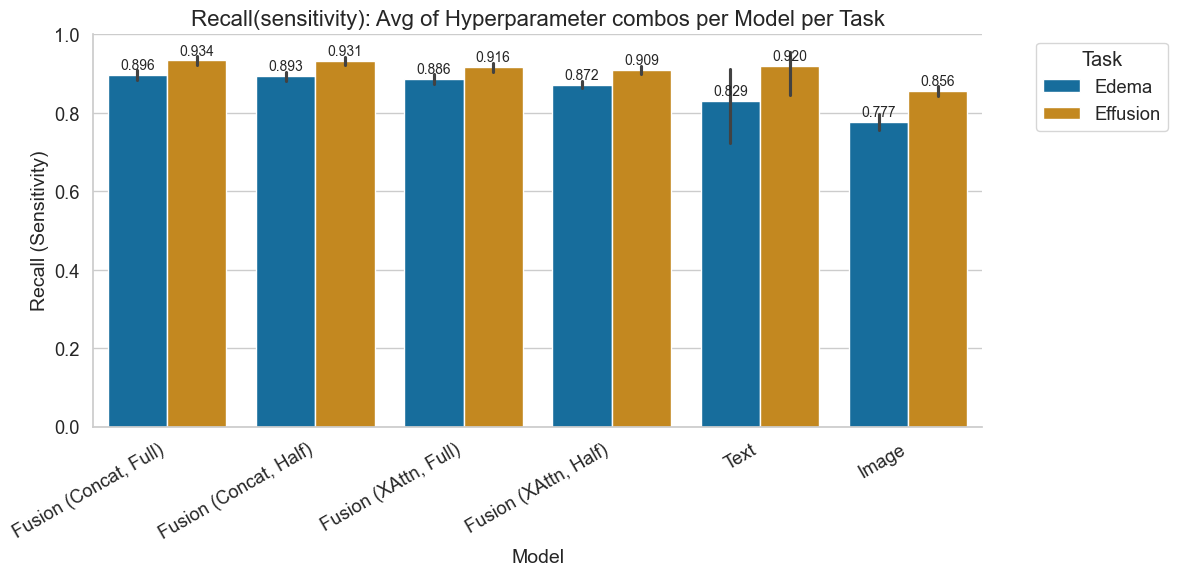

In [3]:
sns.set(style="whitegrid", palette="colorblind", font_scale=1.2)

# Order models by mean F1
order = df.groupby("Model")["Recall"].mean().sort_values(ascending=False).index

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=df, x="Model", y="Recall", hue="Task",
    order=order
)
plt.title("Recall(sensitivity): Avg of Hyperparameter combos per Model per Task", fontsize=16)
plt.xlabel("Model", fontsize=14)
plt.ylabel("Recall (Sensitivity)", fontsize=14)
plt.xticks(rotation=30, ha="right")
plt.legend(title="Task", bbox_to_anchor=(1.05, 1), loc="upper left")
sns.despine()

# Add value labels
for c in ax.containers:
    ax.bar_label(c, fmt="%.3f", padding=2, fontsize=10)

plt.tight_layout()
plt.show()

### Recall (Sensitivity) Metric (Best Hyperparameter)

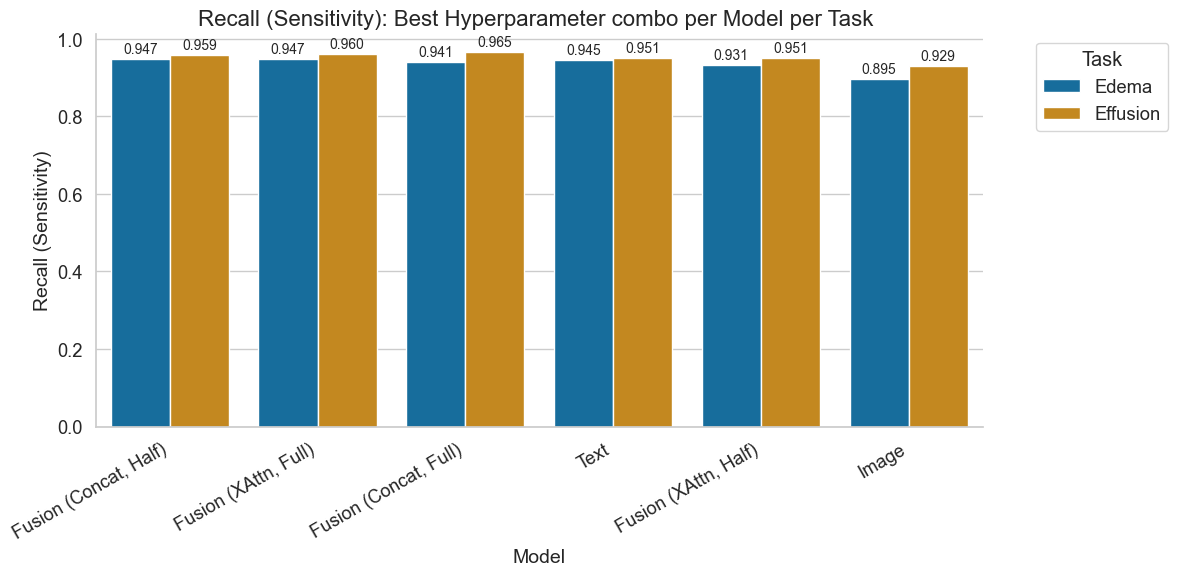

In [4]:
# Load the filtered CSV with best Name per model for Edema & Effusion
df_best = pd.read_csv("best_metrics_by_model.csv")

# Set seaborn style
sns.set(style="whitegrid", palette="colorblind", font_scale=1.2)

# Order models by mean Recall
order = df_best.groupby("Model")["Recall"].mean().sort_values(ascending=False).index

# Create the barplot
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=df_best, x="Model", y="Recall", hue="Task",
    order=order
)

# Plot customization
plt.title("Recall (Sensitivity): Best Hyperparameter combo per Model per Task ", fontsize=16)
plt.xlabel("Model", fontsize=14)
plt.ylabel("Recall (Sensitivity)", fontsize=14)
plt.xticks(rotation=30, ha="right")
plt.legend(title="Task", bbox_to_anchor=(1.05, 1), loc="upper left")
sns.despine()

# Add value labels to bars
for container in ax.containers:
    ax.bar_label(container, fmt="%.3f", padding=2, fontsize=10)

plt.tight_layout()
plt.show()


### F1-Score Metric (Average of Hyperparameters)

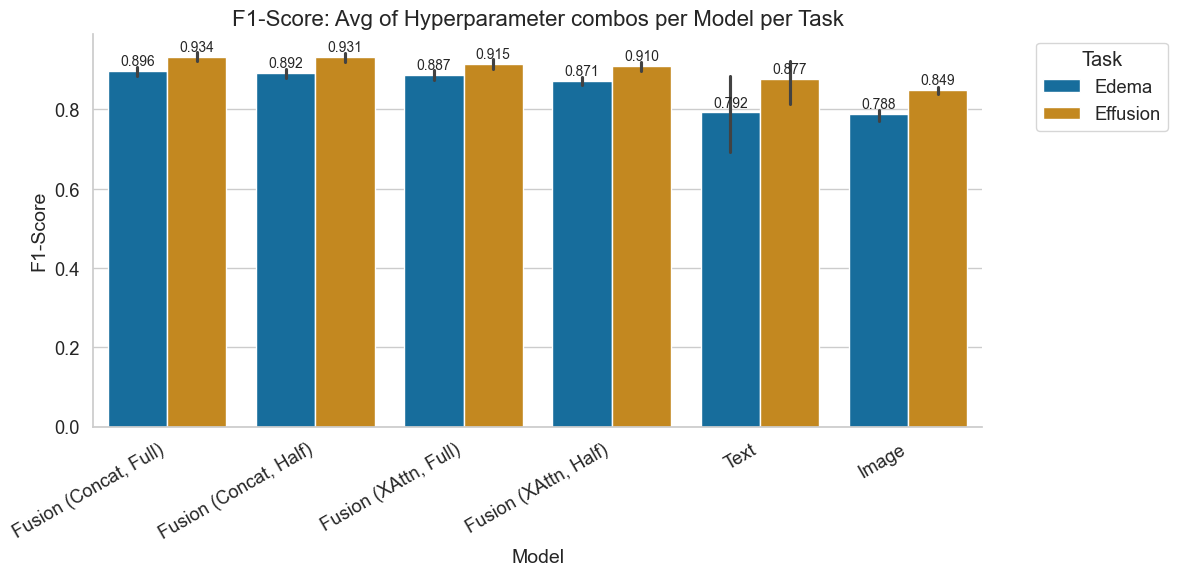

In [5]:
sns.set(style="whitegrid", palette="colorblind", font_scale=1.2)

# Order models by mean F1
order = df.groupby("Model")["F1"].mean().sort_values(ascending=False).index

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=df, x="Model", y="F1", hue="Task",
    order=order
)
plt.title("F1-Score: Avg of Hyperparameter combos per Model per Task", fontsize=16)
plt.xlabel("Model", fontsize=14)
plt.ylabel("F1-Score", fontsize=14)
plt.xticks(rotation=30, ha="right")
plt.legend(title="Task", bbox_to_anchor=(1.05, 1), loc="upper left")
sns.despine()

# Add value labels
for c in ax.containers:
    ax.bar_label(c, fmt="%.3f", padding=2, fontsize=10)

plt.tight_layout()
plt.show()


### F1-Score Metric (Best Hyperparameter)

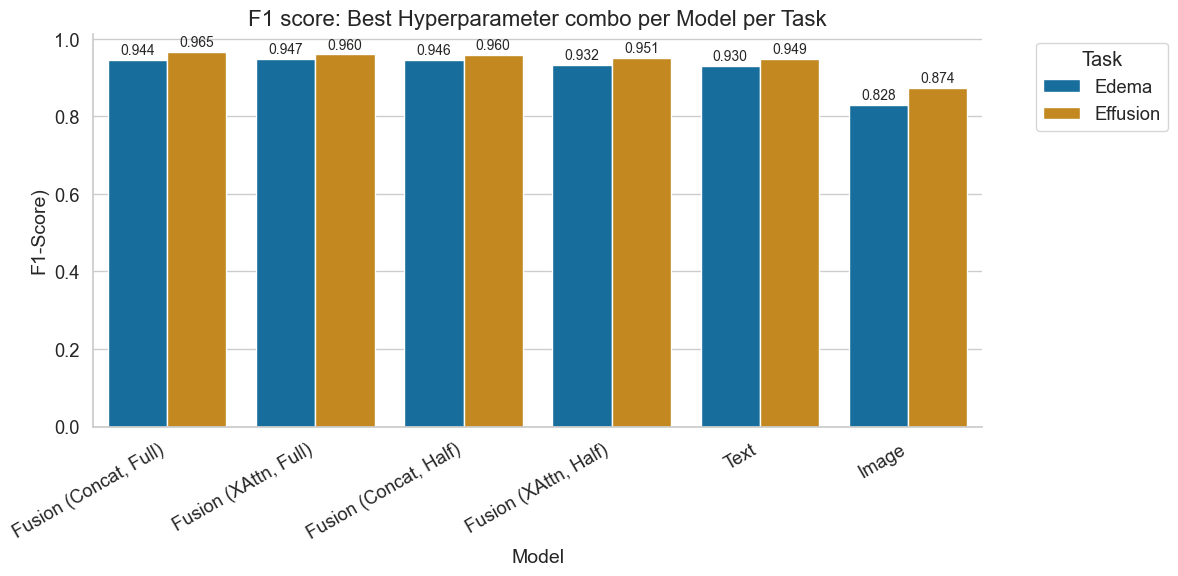

In [6]:
# Load the filtered CSV with best Name per model for Edema & Effusion
df_best = pd.read_csv("best_metrics_by_model.csv")

# Set seaborn style
sns.set(style="whitegrid", palette="colorblind", font_scale=1.2)

# Order models by mean Recall
order = df_best.groupby("Model")["F1"].mean().sort_values(ascending=False).index

# Create the barplot
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=df_best, x="Model", y="F1", hue="Task",
    order=order
)

# Plot customization
plt.title("F1 score: Best Hyperparameter combo per Model per Task", fontsize=16)
plt.xlabel("Model", fontsize=14)
plt.ylabel("F1-Score)", fontsize=14)
plt.xticks(rotation=30, ha="right")
plt.legend(title="Task", bbox_to_anchor=(1.05, 1), loc="upper left")
sns.despine()

# Add value labels to bars
for container in ax.containers:
    ax.bar_label(container, fmt="%.3f", padding=2, fontsize=10)

plt.tight_layout()
plt.show()


### AUPRC Metric (Avg of Hyperparameter combos)

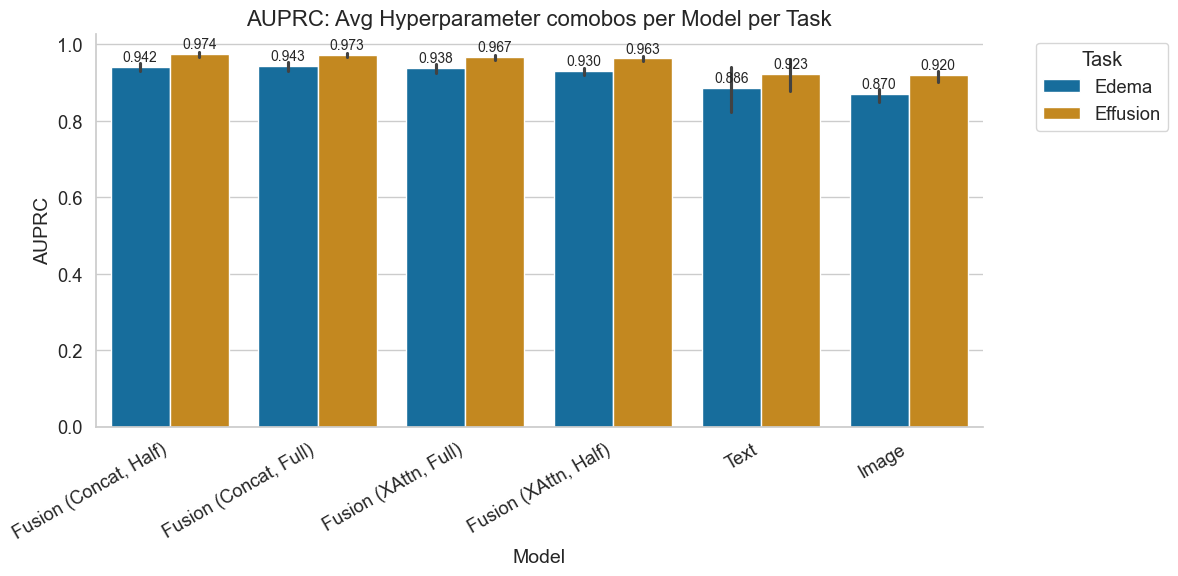

In [7]:
sns.set(style="whitegrid", palette="colorblind", font_scale=1.2)

# Order models by mean F1
order = df.groupby("Model")["AUPRC"].mean().sort_values(ascending=False).index

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=df, x="Model", y="AUPRC", hue="Task",
    order=order
)
plt.title("AUPRC: Avg Hyperparameter comobos per Model per Task", fontsize=16)
plt.xlabel("Model", fontsize=14)
plt.ylabel("AUPRC", fontsize=14)
plt.xticks(rotation=30, ha="right")
plt.legend(title="Task", bbox_to_anchor=(1.05, 1), loc="upper left")
sns.despine()

# Add value labels
for c in ax.containers:
    ax.bar_label(c, fmt="%.3f", padding=2, fontsize=10)

plt.tight_layout()
plt.show()

### AUPRC Metric (Best Hyperparameter Combo)

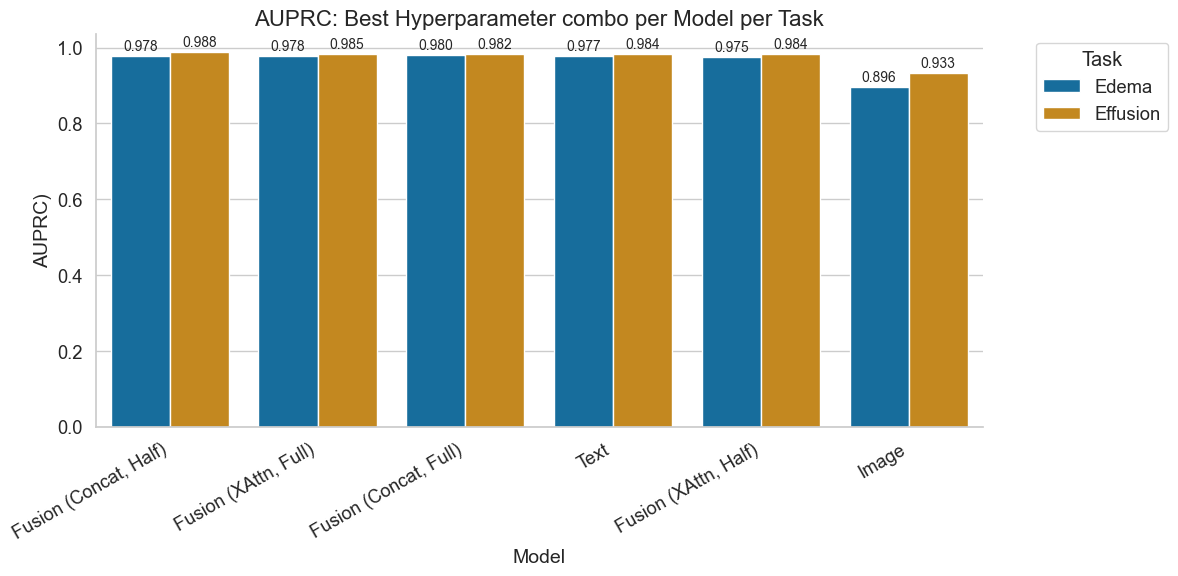

In [8]:
# Load the filtered CSV with best Name per model for Edema & Effusion
df_best = pd.read_csv("best_metrics_by_model.csv")

# Set seaborn style
sns.set(style="whitegrid", palette="colorblind", font_scale=1.2)

# Order models by mean Recall
order = df_best.groupby("Model")["AUPRC"].mean().sort_values(ascending=False).index

# Create the barplot
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=df_best, x="Model", y="AUPRC", hue="Task",
    order=order
)

# Plot customization
plt.title("AUPRC: Best Hyperparameter combo per Model per Task", fontsize=16)
plt.xlabel("Model", fontsize=14)
plt.ylabel("AUPRC)", fontsize=14)
plt.xticks(rotation=30, ha="right")
plt.legend(title="Task", bbox_to_anchor=(1.05, 1), loc="upper left")
sns.despine()

# Add value labels to bars
for container in ax.containers:
    ax.bar_label(container, fmt="%.3f", padding=2, fontsize=10)

plt.tight_layout()
plt.show()


## Average Performance Metrics

In [9]:
agg = df.groupby("Model")[["F1", "AUROC", "AUPRC"]].mean().sort_values("F1", ascending=False)
print("Average Metrics Across Tasks:\n", agg)


Average Metrics Across Tasks:
                              F1     AUROC     AUPRC
Model                                              
Fusion (Concat, Full)  0.914851  0.965793  0.957738
Fusion (Concat, Half)  0.911675  0.964807  0.957786
Fusion (XAttn, Full)   0.901009  0.960328  0.952571
Fusion (XAttn, Half)   0.890358  0.954196  0.946609
Text                   0.834729  0.902479  0.904520
Image                  0.818600  0.907163  0.895320


## Hyperparameter Sensitivity

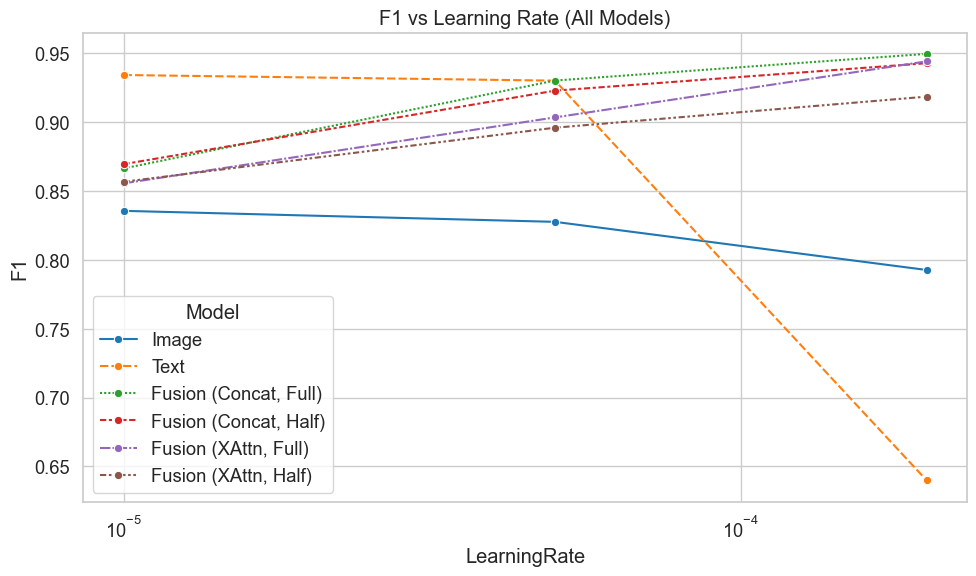

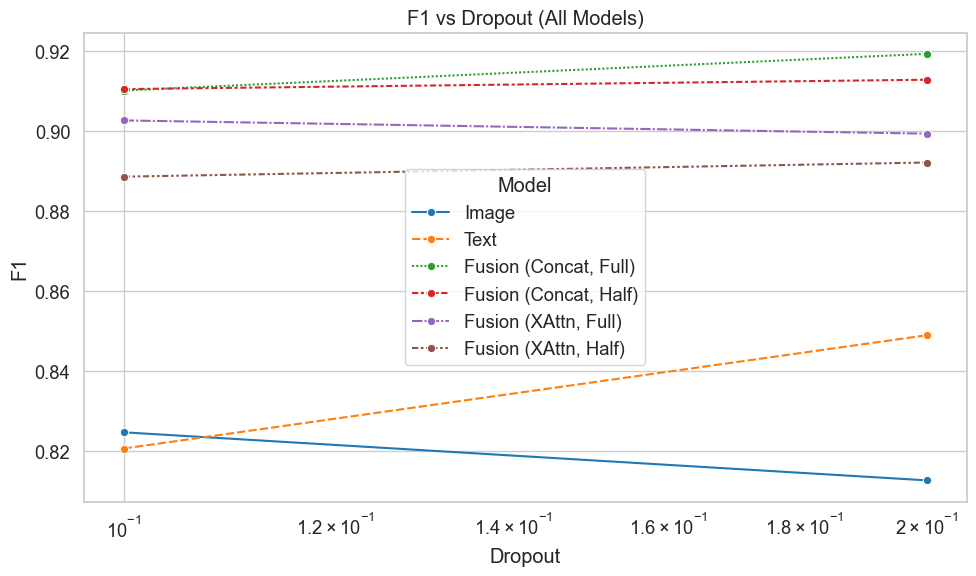

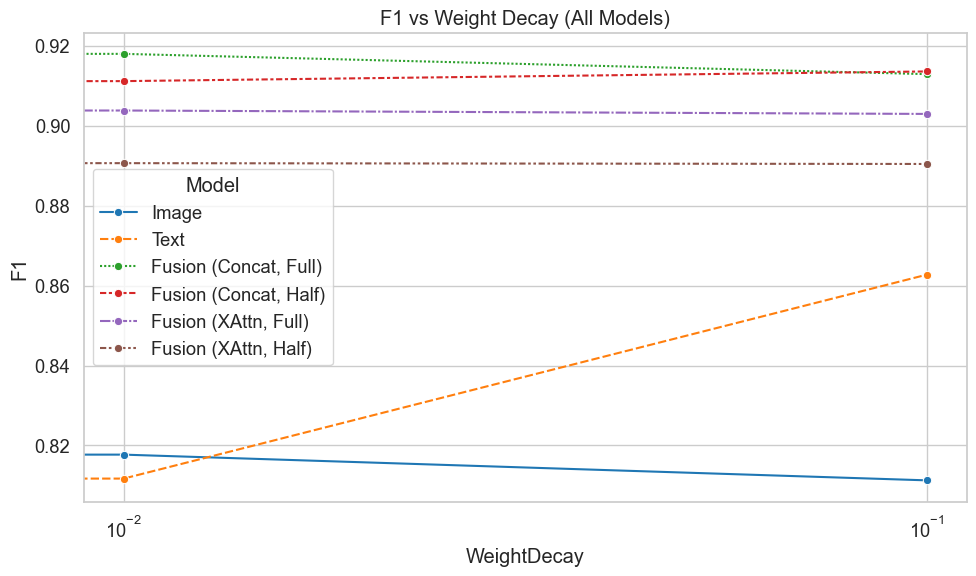

In [10]:
relevant_models = [
    "Fusion (Concat, Full)",
    "Fusion (Concat, Half)",
    "Fusion (XAttn, Full)",
    "Fusion (XAttn, Half)",
    "Image",
    "Text"
]

plot_df = df[df["Model"].isin(relevant_models)]

# F1 vs Learning Rate (line chart, no confidence interval/shadow)
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=plot_df,
    x="LearningRate", y="F1", hue="Model", style="Model", marker="o", palette="tab10", errorbar=None
)
plt.title("F1 vs Learning Rate (All Models)")
plt.xscale("log")
plt.tight_layout()
plt.show()

# F1 vs Dropout (line chart, no confidence interval/shadow)
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=plot_df,
    x="Dropout", y="F1", hue="Model", style="Model", marker="o", palette="tab10", errorbar=None
)
plt.title("F1 vs Dropout (All Models)")
plt.xscale("log")
plt.tight_layout()
plt.show()

# F1 vs Weight Decay (line chart, no confidence interval/shadow)
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=plot_df,
    x="WeightDecay", y="F1", hue="Model", style="Model", marker="o", palette="tab10", errorbar=None
)
plt.title("F1 vs Weight Decay (All Models)")
plt.xscale("log")
plt.tight_layout()
plt.show()


## Task-wise Model Strength

In [11]:
task_model_perf = df.groupby(["Task", "Model"])[["F1", "AUROC"]].mean().reset_index()
print("Task-wise Model Strength:\n", task_model_perf.pivot(index="Model", columns="Task", values="F1"))


Task-wise Model Strength:
 Task                      Edema  Effusion
Model                                    
Fusion (Concat, Full)  0.896112  0.933590
Fusion (Concat, Half)  0.891975  0.931375
Fusion (XAttn, Full)   0.886631  0.915387
Fusion (XAttn, Half)   0.871053  0.909663
Image                  0.788269  0.848930
Text                   0.792396  0.877062


## Reporting Summary Table (Top Configs)

In [12]:
# Compute average F1 per (Model, Name) across tasks
avg_metrics = df.groupby(["Model", "Name"]).agg({
    "F1": "mean",
    "AUROC": "mean",
    "AUPRC": "mean"
}).reset_index()

# Pick the best Name (hyperparam config) per Model based on average F1
best_configs = avg_metrics.sort_values("F1", ascending=False).groupby("Model").head(1)

# Rename columns for clarity
best_configs = best_configs.rename(columns={
    "Name": "Best_Hyperparam_Config",
    "F1": "Avg_F1",
    "AUROC": "Avg_AUROC",
    "AUPRC": "Avg_AUPRC"
})

# Reorder columns
best_configs = best_configs[["Model", "Best_Hyperparam_Config", "Avg_F1", "Avg_AUROC", "Avg_AUPRC"]]

print("Summary Table: Best Hyperparameter Configuration Per Model")
print(best_configs)


Summary Table: Best Hyperparameter Configuration Per Model
                     Model                    Best_Hyperparam_Config  \
11   Fusion (Concat, Full)      VD0.1_TD0.2_LR0.0002_WD0.1_BS16_EP20   
76    Fusion (XAttn, Full)   CA_VD0.1_TD0.1_LR0.0002_WD0.1_BS16_EP20   
40   Fusion (Concat, Half)      VD0.1_TD0.1_LR0.0002_WD0.1_BS16_EP20   
111   Fusion (XAttn, Half)  CA_VD0.1_TD0.1_LR0.0002_WD0.01_BS16_EP20   
210                   Text                  dp0.1_wd0.1_lr1e-05_bs32   
181                  Image                 dp0.2_wd0.01_lr5e-05_bs32   

       Avg_F1  Avg_AUROC  Avg_AUPRC  
11   0.954740   0.984616   0.981337  
76   0.953254   0.985250   0.981393  
40   0.952955   0.983339   0.983008  
111  0.941565   0.979047   0.979340  
210  0.939307   0.981149   0.980825  
181  0.851086   0.927446   0.914467  


## Ablation Study

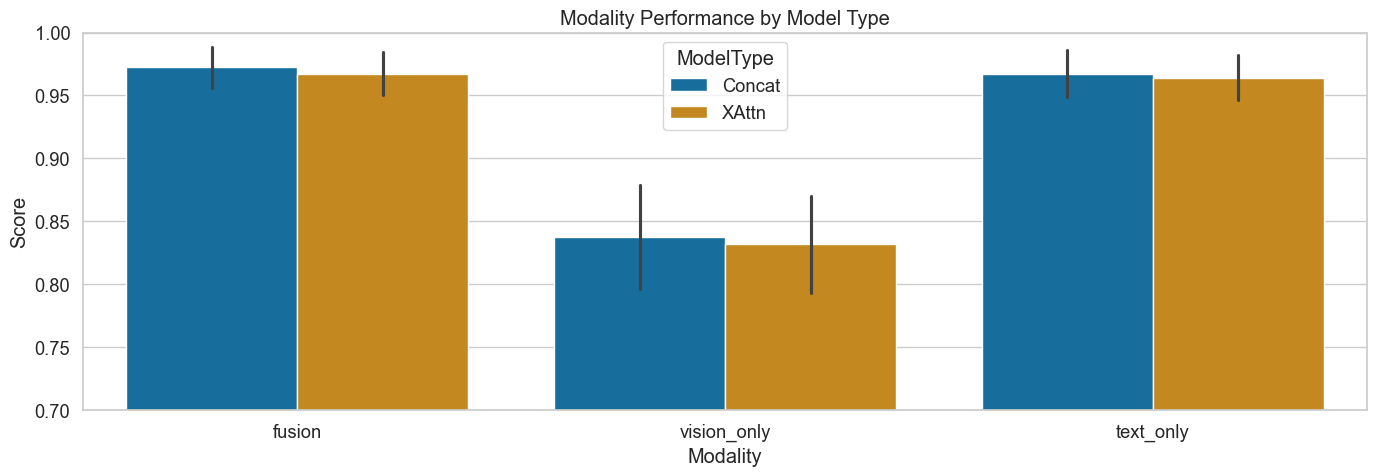

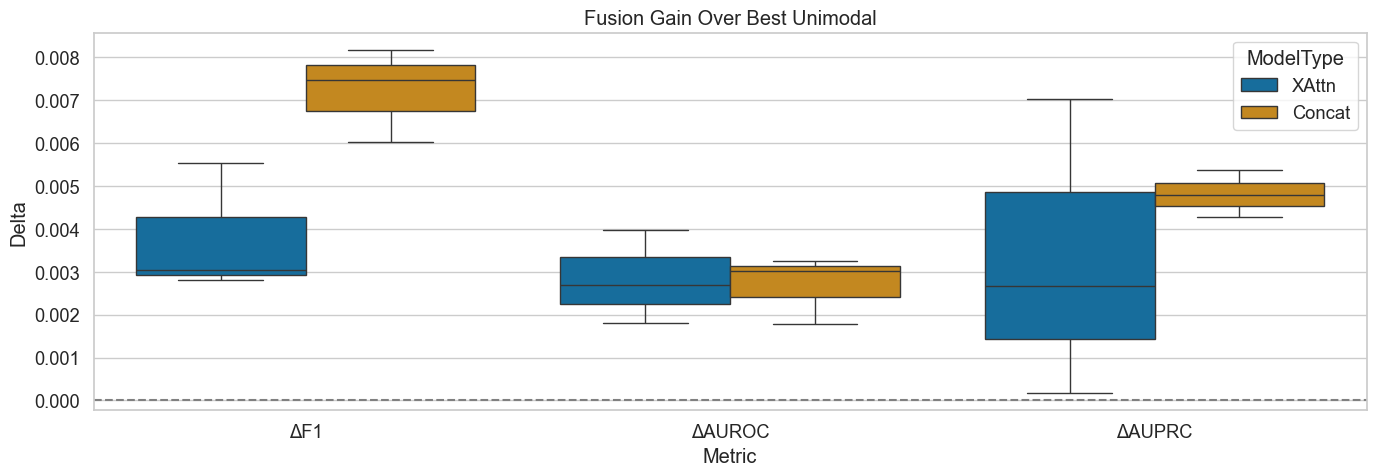

In [13]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load Data ---
with open("../fusion_models/ablation_study_results.json", "r") as f:
    results = json.load(f)

# --- Extract and Aggregate Metrics ---
records = []
for run in results:
    name = run["name"]
    model_type = "Concat" if name.startswith("VD") else "XAttn"
    metrics = run["metrics"]

    for modality in ["fusion", "vision_only", "text_only"]:
        f1s, aurocs, auprcs = [], [], []
        for task in ["edema", "effusion"]:
            m = metrics[modality][task]
            f1s.append(sum(m["f1"]) / 2)
            aurocs.append(m["auroc"])
            auprcs.append(m["auprc"])

        records.append({
            "ModelName": name,
            "ModelType": model_type,
            "Modality": modality,
            "F1": sum(f1s)/2,
            "AUROC": sum(aurocs)/2,
            "AUPRC": sum(auprcs)/2
        })

df = pd.DataFrame(records)

# --- Plot 1: Grouped Bar Plot – Modality Performance by Model Type ---
melted_df = pd.melt(
    df,
    id_vars=["ModelType", "Modality"],
    value_vars=["F1", "AUROC", "AUPRC"],
    var_name="Metric",
    value_name="Score"
)

plt.figure(figsize=(14, 5))
sns.barplot(
    data=melted_df,
    x="Modality",
    y="Score",
    hue="ModelType",
    errorbar="sd",
    estimator="mean"
)
plt.title("Modality Performance by Model Type")
plt.ylim(0.7, 1.0)
plt.ylabel("Score")
plt.tight_layout()
plt.show()

# --- Plot 2: Delta Plot – Fusion Gain over Best Unimodal ---
def fusion_delta(group):
    fusion_row = group[group.Modality == "fusion"].iloc[0]
    text_row = group[group.Modality == "text_only"].iloc[0]
    vision_row = group[group.Modality == "vision_only"].iloc[0]

    deltas = {
        "ModelName": fusion_row["ModelName"],
        "ModelType": fusion_row["ModelType"]
    }
    for metric in ["F1", "AUROC", "AUPRC"]:
        best_unimodal = max(text_row[metric], vision_row[metric])
        delta = fusion_row[metric] - best_unimodal
        deltas[f"Δ{metric}"] = delta
    return deltas

delta_df = pd.DataFrame([fusion_delta(g) for _, g in df.groupby("ModelName")])

# Plot delta boxplot
plt.figure(figsize=(14, 5))
melted_delta = pd.melt(
    delta_df,
    id_vars=["ModelType"],
    value_vars=["ΔF1", "ΔAUROC", "ΔAUPRC"],
    var_name="Metric",
    value_name="Delta"
)
sns.boxplot(data=melted_delta, x="Metric", y="Delta", hue="ModelType")
plt.axhline(0, ls="--", color="gray")
plt.title("Fusion Gain Over Best Unimodal")
plt.tight_layout()
plt.show()

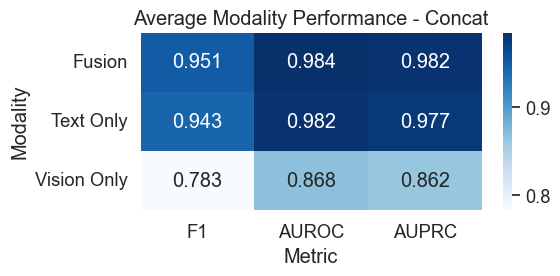

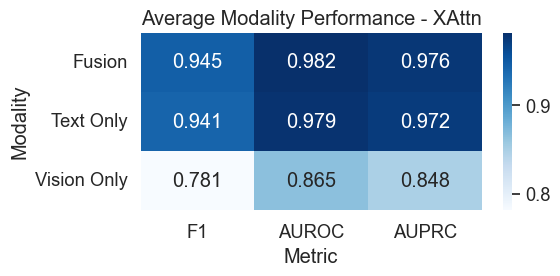

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group by ModelType and Modality, average across tasks & configs
agg_df = df.groupby(["ModelType", "Modality"])[["F1", "AUROC", "AUPRC"]].mean().reset_index()

# For each ModelType (Concat / XAttn), create a heatmap
for model_type in ["Concat", "XAttn"]:
    subset = agg_df[agg_df["ModelType"] == model_type].copy()
    
    # Rename modalities for clarity
    subset["Modality"] = subset["Modality"].map({
        "text_only": "Text Only",
        "vision_only": "Vision Only",
        "fusion": "Fusion"
    })

    # Set Modality as index
    heatmap_data = subset.set_index("Modality")[["F1", "AUROC", "AUPRC"]]

    # Plot
    plt.figure(figsize=(6, 3))
    sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="Blues", cbar=True)
    plt.title(f"Average Modality Performance - {model_type}")
    plt.xlabel("Metric")
    plt.ylabel("Modality")
    plt.tight_layout()
    plt.show()


In [15]:
import pandas as pd

# Step 1: Group by ModelType and Modality, compute mean metrics
avg_df = df.groupby(["ModelType", "Modality"])[["F1", "AUROC", "AUPRC"]].mean().reset_index()

# Step 2: Pivot so that each model type has its 3 modalities as columns
pivoted = avg_df.pivot(index="ModelType", columns="Modality", values=["F1", "AUROC", "AUPRC"])

# Step 3: Build delta table
delta_rows = []

for model_type in pivoted.index:
    row = {
        "ModelType": model_type,

        # Raw metrics
        "Text_F1": pivoted.loc[model_type, ("F1", "text_only")],
        "Vision_F1": pivoted.loc[model_type, ("F1", "vision_only")],
        "Fusion_F1": pivoted.loc[model_type, ("F1", "fusion")],

        "FusionOverTextGain_F1": pivoted.loc[model_type, ("F1", "fusion")] - pivoted.loc[model_type, ("F1", "text_only")],
        "FusionOverVisionGain_F1": pivoted.loc[model_type, ("F1", "fusion")] - pivoted.loc[model_type, ("F1", "vision_only")],

        "Text_AUROC": pivoted.loc[model_type, ("AUROC", "text_only")],
        "Vision_AUROC": pivoted.loc[model_type, ("AUROC", "vision_only")],
        "Fusion_AUROC": pivoted.loc[model_type, ("AUROC", "fusion")],

        "FusionOverTextGain_AUROC": pivoted.loc[model_type, ("AUROC", "fusion")] - pivoted.loc[model_type, ("AUROC", "text_only")],
        "FusionOverVisionGain_AUROC": pivoted.loc[model_type, ("AUROC", "fusion")] - pivoted.loc[model_type, ("AUROC", "vision_only")],

        "Text_AUPRC": pivoted.loc[model_type, ("AUPRC", "text_only")],
        "Vision_AUPRC": pivoted.loc[model_type, ("AUPRC", "vision_only")],
        "Fusion_AUPRC": pivoted.loc[model_type, ("AUPRC", "fusion")],

        "FusionOverTextGain_AUPRC": pivoted.loc[model_type, ("AUPRC", "fusion")] - pivoted.loc[model_type, ("AUPRC", "text_only")],
        "FusionOverVisionGain_AUPRC": pivoted.loc[model_type, ("AUPRC", "fusion")] - pivoted.loc[model_type, ("AUPRC", "vision_only")],
    }
    delta_rows.append(row)

# Step 4: Create DataFrame
delta_table_df = pd.DataFrame(delta_rows)

# Step 5: Format delta columns
for col in delta_table_df.columns:
    if "Gain" in col:
        delta_table_df[col] = delta_table_df[col].map(lambda x: f"+{x:.4f}" if x >= 0 else f"{x:.4f}")

# Step 6: Display final table
print("\n=== Fusion vs Unimodal (Avg. over Hyperparams) ===")
print(delta_table_df.to_string(index=False))



=== Fusion vs Unimodal (Avg. over Hyperparams) ===
ModelType  Text_F1  Vision_F1  Fusion_F1 FusionOverTextGain_F1 FusionOverVisionGain_F1  Text_AUROC  Vision_AUROC  Fusion_AUROC FusionOverTextGain_AUROC FusionOverVisionGain_AUROC  Text_AUPRC  Vision_AUPRC  Fusion_AUPRC FusionOverTextGain_AUPRC FusionOverVisionGain_AUPRC
   Concat 0.943327   0.783304   0.950554               +0.0072                 +0.1673    0.981739      0.867626      0.984426                  +0.0027                    +0.1168    0.976973      0.862047      0.981787                  +0.0048                    +0.1197
    XAttn 0.941165   0.781281   0.944964               +0.0038                 +0.1637    0.978675      0.865423      0.981506                  +0.0028                    +0.1161    0.972393      0.847881      0.975684                  +0.0033                    +0.1278
